In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import dill
import copy
import numpy as np

In [2]:
test_nodes = [
    "15",
    "71",
    "0",
    "87",
    "19",
    "120",
    "85",
    "127",
    "32",
    "149",
    "38",
    "23",
    "126",
    "72",
    "7",
    "66",
    "2",
    "31",
    "128",
    "130",
    "89",
    "115",
    "131",
    "79",
    "36",
    "77",
    "81",
    "117",
    "140",
    "57",
    "53",
    "30",
    "139",
    "21",
    "138",
    "141",
    "142",
    "50",
    "78",
    "116",
    "12",
    "83",
    "56",
    "64",
    "24",
    "61",
    "92",
    "84",
    "34",
    "6",
]

counters_nodes = dill.load(open("./selected.pkl", "rb"))
test_nodes_columns_disparity_dataset = [
    f"Test Node {name} - Disp. Dataset" for name in test_nodes
]


test_nodes_columns_accuracy = [f"Test Node {name} - Acc." for name in test_nodes]
test_nodes_columns_disparity = [f"Test Node {name} - Disp." for name in test_nodes]


test_nodes_columns_test_accuracy = "Test Disparity"
test_nodes_columns_test_disparity = "Test Accuracy"

In [3]:
def get_train_nodes(df):
    train_nodes_tmp = list(set([str(item) for item in range(0, 150)]) - set(test_nodes))

    train_nodes = []
    for node in train_nodes_tmp:
        if f"Disparity Client {node} After Local train" in df.columns:
            train_nodes.append(node)

    train_nodes_columns_lambda = [
        f"Lambda Client {node_name}" for node_name in train_nodes
    ]
    train_nodes_columns_disparity_dataset = [
        f"Disparity Dataset Client {name}" for name in train_nodes
    ]
    train_nodes_columns_disparity = [
        f"Disparity Client {node_name} After Local train" for node_name in train_nodes
    ]
    train_nodes_columns_disparity_before = [
        f"Disparity Client {node_name} Before local train" for node_name in train_nodes
    ]
    return (
        train_nodes,
        train_nodes_columns_lambda,
        train_nodes_columns_disparity_dataset,
        train_nodes_columns_disparity,
        train_nodes_columns_disparity_before,
    )

In [4]:
counters_nodes = dill.load(open("./not_selected.pkl", "rb"))
node_disparities_fair = {}
node_disparities_unfair = {}

for node_name, node_info in counters_nodes.items():
    disparity = node_info[0]
    if disparity < 0.1:
        node_disparities_fair[node_name] = disparity
    else:
        node_disparities_unfair[node_name] = disparity

In [5]:
# train_nodes = dill.load(open('./not_selected.pkl', 'rb'))
# node_disparities_fair = {}
# node_disparities_unfair = {}

# for node_name, node_info in train_nodes.items():
#     disparity = node_info[0]
#     if disparity < 0.1:
#         node_disparities_fair[node_name] = disparity
#     else:
#         node_disparities_unfair[node_name] = disparity
# print(len(node_disparities_fair))
# print(len(node_disparities_unfair))

In [6]:
def get_df(api_link):
    api = wandb.Api()
    run = api.run(api_link)
    df = pd.DataFrame(run.scan_history())
    return df


def remove_nan(column_names, dataframe):
    
    column_names = [column_name for column_name in column_names if column_name in dataframe.columns]

    current_df = dataframe[column_names]
    # consider each column in training_data_disparity independently and
    # remove the rows where we have NaN
    new_columns = []

    for column in current_df.columns:
        
        new_values = list(current_df[column].dropna())
        new_columns.append(new_values)

    # if the lists have different lengths, we need to modify them so that
    # we have the same length:
    min_size = min([len(item) for item in new_columns])
    new_columns = [item[:min_size] for item in new_columns]

    # create the new dataframe with baseline_test_nodes_columns_disparity_dataset as columns
    # names and new_columns as values
    new_df = pd.DataFrame(dict(zip(column_names, new_columns)))
    return new_df

In [7]:
def plot_disparity_dataset(df, node_names, file_name, title):
    nodes_with_disparity = {}
    for node_name, column in zip(node_names, df.columns):
        # get the last value of the column
        nodes_with_disparity[node_name] = df[column].iloc[-1]

    figure(figsize=(20, 8), dpi=80)
    # sort the nodes by disparity
    nodes_with_disparity = dict(
        sorted(nodes_with_disparity.items(), key=lambda item: item[1])
    )
    plt.bar(nodes_with_disparity.keys(), nodes_with_disparity.values())
    plt.xlabel("Nodes")
    plt.ylabel("Disparity")
    # font size
    plt.rcParams.update({"font.size": 20})
    # rotate xticks
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title(title)
    plt.savefig(file_name)

    return nodes_with_disparity.keys(), nodes_with_disparity.values()


def plot_different_distributions(counters_nodes, sorted_nodes, file_name):
    # we want to plot the different distributions of the nodes
    # in particular the amount of samples of group (0,1) and (1,1)
    one_zeros = []
    one_ones = []
    for node_name in sorted_nodes:
        one_zero = counters_nodes[node_name][1][(0, 1)]
        one_one = counters_nodes[node_name][1][(1, 1)]
        one_zeros.append(one_zero)
        one_ones.append(one_one)

    # plot a grouped bar chart with the values of one_zeros and one_ones
    # for each node. For each node I want to show two bars, one for one_zeros
    # and one for one_ones
    figure(figsize=(25, 8), dpi=80)
    plt.bar(sorted_nodes, one_zeros, width=0.4, align="edge")
    plt.bar(sorted_nodes, one_ones, width=-0.4, align="edge")
    plt.legend(["(0,1)", "(1,1)"])
    plt.xlabel("Nodes")
    plt.ylabel("Number of samples")
    # font size
    plt.rcParams.update({"font.size": 17})
    # rotate xticks
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title("Distribution of samples (1,1) and (0,1) in the test nodes")
    plt.savefig(file_name)


# def plot_fixed_vs_tunable(baseline, fixed, tunable, nodes, file_name, sorted_nodes, target):
#     baseline_disparity_dict = {}
#     fixed_disparity_dict = {}
#     tunable_disparit_dict = {}
#     for node_name, column in zip(nodes, baseline.columns):
#         # get the last value of the column
#         baseline_disparity_dict[node_name] = baseline[column].iloc[-1]
#         fixed_disparity_dict[node_name] = fixed[column].iloc[-1]
#         tunable_disparit_dict[node_name] = tunable[column].iloc[-1]

#     baseline_disparity = []
#     fixed_disparity = []
#     tunable_disparity = []
#     for node in sorted_nodes:
#         baseline_disparity.append(baseline_disparity_dict[node])
#         fixed_disparity.append(fixed_disparity_dict[node])
#         tunable_disparity.append(tunable_disparit_dict[node])

#     width = 0.27
#     figure(figsize=(25, 8), dpi=80)
#     indexes = np.arange(len(nodes))
#     plt.bar(indexes, baseline_disparity, width=width)
#     plt.bar(indexes+width, fixed_disparity, width=width)
#     plt.bar(indexes+width*2, tunable_disparity, width=width)
#     plt.axhline(y=target, color='purple', linestyle='--')
#     plt.legend(["Baseline", "Fixed", "Tunable"])
#     plt.xticks(indexes + width, nodes)
#     plt.rcParams.update({'font.size': 20})
#     plt.xlabel("Nodes")
#     plt.ylabel("Disparity")
#     plt.xticks(rotation=90)
#     plt.title("Comparison between the test disparity of the baseline, fixed and tunable Lambda")
#     plt.savefig(file_name)


def plot_fixed_vs_tunable_line(
    disparity_dataset,
    baseline,
    fixed,
    tunable,
    nodes,
    file_name,
    sorted_nodes,
    target,
    title,
):
    # Plots the final disparity of the baseline, fixed and tunable models for each node
    baseline_disparity_dict = {}
    fixed_disparity_dict = {}
    tunable_disparit_dict = {}

    for node_name, column in zip(nodes, baseline.columns):
        # get the last value of the column
        if column in baseline.columns:
            baseline_disparity_dict[node_name] = baseline[column].iloc[-1]
        if column in fixed.columns:
            fixed_disparity_dict[node_name] = fixed[column].iloc[-1]
        if column in tunable.columns:
            tunable_disparit_dict[node_name] = tunable[column].iloc[-1]

    print(baseline_disparity_dict)
    print(fixed_disparity_dict)
    print(tunable_disparit_dict)

    baseline_disparity = []
    fixed_disparity = []
    tunable_disparity = []
    for node in sorted_nodes:
        if node in baseline_disparity_dict:
            baseline_disparity.append(baseline_disparity_dict[node])
        if node in fixed_disparity_dict:
            fixed_disparity.append(fixed_disparity_dict[node])
        if node in tunable_disparit_dict:
            tunable_disparity.append(tunable_disparit_dict[node])

    # get the training disparity
    nodes_with_disparity = {}
    for node_name, column in zip(nodes, disparity_dataset.columns):
        # get the last value of the column
        nodes_with_disparity[node_name] = disparity_dataset[column].iloc[-1]

    training_disparity = [nodes_with_disparity[node_name] for node_name in sorted_nodes]

    width = 0.27
    figure(figsize=(25, 8), dpi=80)
    indexes = np.arange(len(sorted_nodes))

    plt.scatter(
        indexes, baseline_disparity, marker="x", linewidths=4, s=100, color="red"
    )
    plt.scatter(
        indexes, fixed_disparity, marker="o", linewidths=4, s=100, color="green"
    )
    plt.scatter(
        indexes, tunable_disparity, marker="+", linewidths=4, s=100, color="blue"
    )
    plt.scatter(
        indexes, training_disparity, marker="*", linewidths=4, s=100, color="black"
    )

    plt.plot(indexes, baseline_disparity, linewidth=1, color="red")
    plt.plot(indexes, fixed_disparity, linewidth=1, color="green")
    plt.plot(indexes, tunable_disparity, linewidth=1, color="blue")
    plt.plot(indexes, training_disparity, linewidth=1, color="black")

    plt.axhline(y=target, color="purple", linestyle="--")

    plt.legend(["Baseline", "Fixed", "Tunable", "Dataset Disparity"])
    plt.xticks(indexes, sorted_nodes)
    plt.rcParams.update({"font.size": 16})
    plt.xlabel("Nodes")
    plt.ylabel("Disparity")
    plt.xticks(rotation=90)
    plt.title(title)
    plt.savefig(file_name)


# def plot_difference_disparity(baseline, fixed, tunable, nodes, file_name, sorted_nodes, target):
#     # plot the difference between the disparity of the baseline and the disparity of the fixed
#     # and tunable models. This is a grouped bar chart with 2 bars for each node, one for the fixed
#     # and one for the tunable.
#     baseline_disparity_dict = {}
#     fixed_disparity_dict = {}
#     tunable_disparit_dict = {}
#     for node_name, column in zip(nodes, baseline.columns):
#         # get the last value of the column
#         baseline_disparity_dict[node_name] = baseline[column].iloc[-1]
#         fixed_disparity_dict[node_name] = fixed[column].iloc[-1]
#         tunable_disparit_dict[node_name] = tunable[column].iloc[-1]

#     fixed_disparity = []
#     tunable_disparity = []
#     for node in sorted_nodes:
#         fixed_disparity.append(baseline_disparity_dict[node]-fixed_disparity_dict[node])
#         tunable_disparity.append(baseline_disparity_dict[node]-tunable_disparit_dict[node])

#     width = 0.27
#     figure(figsize=(25, 8), dpi=80)
#     indexes = np.arange(len(nodes))
#     plt.bar(indexes, fixed_disparity, width=width)
#     plt.bar(indexes+width, tunable_disparity, width=width)
#     plt.legend(["Fixed", "Tunable"])
#     plt.xticks(indexes + width, nodes)
#     plt.rcParams.update({'font.size': 20})
#     plt.xlabel("Nodes")
#     plt.ylabel("Difference")
#     plt.xticks(rotation=90)
#     plt.title("Difference between the test disparity of the baseline and the disparity of the fixed and tunable Lambda")
#     plt.savefig(file_name)


def plot_difference_disparity_line(
    baseline, fixed, tunable, nodes, file_name, sorted_nodes, target
):
    # plot the difference between the disparity of the baseline and the disparity of the fixed
    # and tunable models. This is a grouped bar chart with 2 bars for each node, one for the fixed
    # and one for the tunable.
    baseline_disparity_dict = {}
    fixed_disparity_dict = {}
    tunable_disparit_dict = {}
    for node_name, column in zip(nodes, baseline.columns):
        # get the last value of the column
        baseline_disparity_dict[node_name] = baseline[column].iloc[-1]
        fixed_disparity_dict[node_name] = fixed[column].iloc[-1]
        tunable_disparit_dict[node_name] = tunable[column].iloc[-1]

    fixed_disparity = []
    tunable_disparity = []
    for node in sorted_nodes:
        fixed_disparity.append(
            baseline_disparity_dict[node] - fixed_disparity_dict[node]
        )
        tunable_disparity.append(
            baseline_disparity_dict[node] - tunable_disparit_dict[node]
        )

    width = 0.27
    figure(figsize=(25, 8), dpi=80)
    indexes = np.arange(len(sorted_nodes))

    plt.scatter(
        indexes, fixed_disparity, marker="o", linewidths=4, s=100, color="green"
    )
    plt.scatter(
        indexes, tunable_disparity, marker="+", linewidths=4, s=100, color="blue"
    )
    # ax = plt.axes()
    # ax.yaxis.grid()

    plt.plot(indexes, fixed_disparity, linewidth=1, color="green")
    plt.plot(indexes, tunable_disparity, linewidth=1, color="blue")
    plt.legend(["Fixed", "Tunable"])
    plt.xticks(indexes, sorted_nodes)
    plt.rcParams.update({"font.size": 20})
    plt.xlabel("Nodes")
    plt.ylabel("Difference")
    plt.xticks(rotation=90)
    plt.title(
        "Difference between the test disparity of the baseline and the disparity of the fixed and tunable Lambda (At LAST FL ROUND)"
    )
    plt.savefig(file_name)

In [8]:
# def plot_fixed_vs_tunable_accuracy(baseline, fixed, tunable, nodes, file_name, sorted_nodes, target):
#     # Plots the final accuracy of the baseline, fixed and tunable models for each node
#     baseline_disparity_dict = {}
#     fixed_disparity_dict = {}
#     tunable_disparit_dict = {}
#     for node_name, column in zip(nodes, baseline.columns):
#         # get the last value of the column
#         baseline_disparity_dict[node_name] = baseline[column].iloc[-1]
#         fixed_disparity_dict[node_name] = fixed[column].iloc[-1]
#         tunable_disparit_dict[node_name] = tunable[column].iloc[-1]

#     baseline_disparity = []
#     fixed_disparity = []
#     tunable_disparity = []
#     for node in sorted_nodes:
#         baseline_disparity.append(baseline_disparity_dict[node])
#         fixed_disparity.append(fixed_disparity_dict[node])
#         tunable_disparity.append(tunable_disparit_dict[node])

#     width = 0.27
#     figure(figsize=(25, 8), dpi=80)
#     indexes = np.arange(len(nodes))
#     plt.bar(indexes, baseline_disparity, width=width)
#     plt.bar(indexes+width, fixed_disparity, width=width)
#     plt.bar(indexes+width*2, tunable_disparity, width=width)
#     # plt.axhline(y=target, color='purple', linestyle='--')
#     plt.legend(["Baseline", "Fixed", "Tunable"])
#     plt.xticks(indexes + width, nodes)
#     plt.rcParams.update({'font.size': 20})
#     plt.xlabel("Nodes")
#     plt.ylabel("Accuracy")
#     plt.xticks(rotation=90)
#     plt.title("Comparison between the test accuracy of the baseline, fixed and tunable Lambda")
#     plt.savefig(file_name)


def plot_fixed_vs_tunable_accuracy_line(
    baseline, fixed, tunable, nodes, file_name, sorted_nodes, target
):
    # Plots the final accuracy of the baseline, fixed and tunable models for each node
    baseline_disparity_dict = {}
    fixed_disparity_dict = {}
    tunable_disparit_dict = {}
    for node_name, column in zip(nodes, baseline.columns):
        # get the last value of the column
        baseline_disparity_dict[node_name] = baseline[column].iloc[-1]
        fixed_disparity_dict[node_name] = fixed[column].iloc[-1]
        tunable_disparit_dict[node_name] = tunable[column].iloc[-1]

    baseline_disparity = []
    fixed_disparity = []
    tunable_disparity = []
    for node in sorted_nodes:
        baseline_disparity.append(baseline_disparity_dict[node])
        fixed_disparity.append(fixed_disparity_dict[node])
        tunable_disparity.append(tunable_disparit_dict[node])

    width = 0.27
    figure(figsize=(25, 8), dpi=80)
    indexes = np.arange(len(nodes))

    # plt.axhline(y=target, color='purple', linestyle='--')

    plt.scatter(
        indexes, baseline_disparity, marker="x", linewidths=3, s=100, color="red"
    )
    plt.scatter(
        indexes, fixed_disparity, marker="o", linewidths=3, s=100, color="green"
    )
    plt.scatter(
        indexes, tunable_disparity, marker="+", linewidths=3, s=100, color="blue"
    )

    plt.plot(indexes, baseline_disparity, linewidth=1, color="red")
    plt.plot(indexes, fixed_disparity, linewidth=1, color="green")
    plt.plot(indexes, tunable_disparity, linewidth=1, color="blue")
    # ax = plt.axes()
    # ax.yaxis.grid()

    plt.legend(["Baseline", "Fixed", "Tunable"])
    plt.xticks(indexes, sorted_nodes)
    plt.rcParams.update({"font.size": 20})
    plt.xlabel("Nodes")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=90)
    plt.title(
        "Comparison between the test accuracy of the baseline, fixed and tunable Lambda (LAST FL ROUND)"
    )
    plt.savefig(file_name)

In [9]:
def plot_lambda(baseline, fixed, tunable, nodes, file_name, target):
    accuracy_baseline = list(baseline["Aggregated Lambda"].dropna())
    accuracy_fixed = list(fixed["Aggregated Lambda"].dropna())
    accuracy_tunable = list(tunable["Aggregated Lambda"].dropna())

    # plot the three lines
    figure(figsize=(25, 8), dpi=80)
    # grid
    ax = plt.axes()
    ax.yaxis.grid()
    plt.plot(accuracy_baseline, linewidth=2, color="red")
    plt.plot(accuracy_fixed, linewidth=2, color="green")
    plt.plot(accuracy_tunable, linewidth=2, color="blue")
    plt.legend(["Baseline", "Fixed", "Tunable"])
    plt.xlabel("FL Rounds")
    plt.ylabel("Lambda")
    plt.title(f"Comparison of the Lambda in the Baseline, Fixed and Tunable models")
    plt.savefig(file_name)


def plot_accuracy_comparison(baseline, fixed, tunable, nodes, file_name, target):
    accuracy_baseline = list(baseline["Test Accuracy"].dropna())
    accuracy_fixed = list(fixed["Test Accuracy"].dropna())
    accuracy_tunable = list(tunable["Test Accuracy"].dropna())

    # plot the three lines
    figure(figsize=(25, 8), dpi=80)
    # grid
    ax = plt.axes()
    ax.yaxis.grid()
    plt.plot(accuracy_baseline, linewidth=2, color="red")
    plt.plot(accuracy_fixed, linewidth=2, color="green")
    plt.plot(accuracy_tunable, linewidth=2, color="blue")
    plt.legend(["Baseline", "Fixed", "Tunable"])
    plt.xlabel("FL Rounds")
    plt.ylabel("Accuracy")
    plt.title(
        f"Test Accuracy comparison between the baseline, fixed and tunable Lambda"
    )
    plt.savefig(file_name)


def plot_disparity_comparison(baseline, fixed, tunable, nodes, file_name, target, test):
    if test:
        disparity_baseline = list(baseline["Test Disparity with statistics"].dropna())
        disparity_fixed = list(fixed["Test Disparity with statistics"].dropna())
        disparity_tunable = list(tunable["Test Disparity with statistics"].dropna())
    else:
        disparity_baseline = list(
            baseline["Training Disparity with statistics"].dropna()
        )
        disparity_fixed = list(fixed["Training Disparity with statistics"].dropna())
        disparity_tunable = list(tunable["Training Disparity with statistics"].dropna())
    # plot the three lines
    figure(figsize=(25, 8), dpi=80)
    ax = plt.axes()
    ax.yaxis.grid()
    plt.plot(disparity_baseline, linewidth=2, color="red")
    plt.plot(disparity_fixed, linewidth=2, color="green")
    plt.plot(disparity_tunable, linewidth=2, color="blue")
    # plot horizontal line at target
    plt.axhline(y=target, color="purple", linestyle="--")

    plt.legend(["Baseline", "Fixed", "Tunable"])
    plt.xlabel("FL Rounds")
    plt.ylabel("Disparity")
    plt.title(
        "Test Disparity comparison between the baseline, fixed and tunable Lambda"
        if test
        else "Training Disparity comparison between the baseline, fixed and tunable Lambda"
    )
    plt.savefig(file_name)

In [10]:
def plot_lambda_with_std(fixed, tunable, file_name, train_nodes_columns_lambda):
    """
    This function computes the mean and the standard deviation of the lambda
    values of the experiment with tunable Lambda. Before doing this, we have to
    remove the NaN values from the dataframe and to align the values of the
    steps with the values of the fl rounds
    """
    lambdas = [
        list(tunable[column].values)
        for column in tunable[train_nodes_columns_lambda].columns
    ]
    print(len(lambdas[0]))
    # check if it is nan
    print(np.isnan(lambdas[0][0]))
    # get the maximum length of the lambdas list then for each list I want to
    # check element and if I find a value that is not nan I want to append to a list
    tmp_list = []
    fl_round_list = []
    for i in range(len(lambdas[0])):
        for lambda_list in lambdas:
            if not np.isnan(lambda_list[i]):
                if len(tmp_list) < 20:
                    tmp_list.append(lambda_list[i])
                else:
                    fl_round_list.append(copy.deepcopy(tmp_list))
                    tmp_list = []

    # mean of the fl_round_list
    mean_fl_round_list = [np.mean(fl_round) for fl_round in fl_round_list]
    # std of the fl_round_list
    std_fl_round_list = [np.std(fl_round) for fl_round in fl_round_list]

    # plot the mean and the standard deviation with error bars
    figure(figsize=(25, 8), dpi=80)
    ax = plt.axes()
    ax.yaxis.grid()
    plt.errorbar(
        range(len(mean_fl_round_list)),
        mean_fl_round_list,
        yerr=std_fl_round_list,
        fmt="o",
        color="blue",
        ecolor="lightblue",
        elinewidth=3,
        capsize=0,
    )
    plt.rcParams.update({"font.size": 20})
    lambda_fixed = list(fixed["Aggregated Lambda"].dropna())
    plt.plot(lambda_fixed, linewidth=2, color="green")
    plt.plot(mean_fl_round_list, linewidth=2, color="blue")

    plt.legend(["Fixed", "Tunable"])
    plt.xlabel("FL Rounds")
    plt.ylabel("Lambda")
    plt.title("Fixed Lambda vs Avg. Tunable Lambda with std")
    plt.savefig(file_name)

In [11]:
def plot_all_nodes_disparity_dataset(all_values, all_nodes, experiment):

    dictionary = dict(zip(all_nodes, all_values))

    # bar plot with all the nodes
    figure(figsize=(25, 8), dpi=80)
    # sort the nodes by disparity   
    dictionary = dict(sorted(dictionary.items(), key=lambda item: item[1]))
    plt.bar(dictionary.keys(), dictionary.values())
    plt.xlabel("Nodes")
    plt.ylabel("Disparity")
    # font size
    plt.rcParams.update({"font.size": 20})
    # font size of x axis ticks
    plt.xticks(fontsize=10)
    # remove xticks
    plt.xticks([])
    plt.tight_layout()
    plt.title("Disparity Dataset for all nodes")
    plt.savefig(f"all_nodes_disparity_dataset_{experiment}.png")

In [12]:
def process_and_plot(
    baseline_link,
    fixed_link,
    tunable_link,
    experiment,
    target,
    df_baseline=None,
    df_fixed=None,
    df_tunable=None,
):
    if df_baseline is None:
        df_baseline = get_df(baseline_link)

    if df_fixed is None:
        df_fixed = get_df(fixed_link)

    if df_tunable is None:
        df_tunable = get_df(tunable_link)

    (
        train_nodes,
        train_nodes_columns_lambda,
        train_nodes_columns_disparity_dataset,
        train_nodes_columns_disparity,
        train_nodes_columns_disparity_before,
    ) = get_train_nodes(df_fixed)
    print(len(train_nodes))

    baseline_test_nodes_columns_disparity_dataset = remove_nan(
        test_nodes_columns_disparity_dataset, df_baseline
    )
    baseline_test_nodes_columns_accuracy = remove_nan(
        test_nodes_columns_accuracy, df_baseline
    )
    baseline_test_nodes_columns_disparity = remove_nan(
        test_nodes_columns_disparity, df_baseline
    )

    fixed_test_nodes_columns_disparity_dataset = remove_nan(
        test_nodes_columns_disparity_dataset, df_fixed
    )
    fixed_test_nodes_columns_accuracy = remove_nan(
        test_nodes_columns_accuracy, df_fixed
    )
    fixed_test_nodes_columns_disparity = remove_nan(
        test_nodes_columns_disparity, df_fixed
    )

    tunable_test_nodes_columns_disparity_dataset = remove_nan(
        test_nodes_columns_disparity_dataset, df_tunable
    )
    tunable_test_nodes_columns_accuracy = remove_nan(
        test_nodes_columns_accuracy, df_tunable
    )
    tunable_test_nodes_columns_disparity = remove_nan(
        test_nodes_columns_disparity, df_tunable
    )

    # Be sure that we do not consider the validation nodes in the train nodes

    current_columns = []
    for column_name in train_nodes_columns_disparity_dataset:
        if column_name in df_baseline.columns:
            current_columns.append(column_name)

    baseline_train_nodes_columns_disparity_dataset = remove_nan(
        current_columns, df_baseline
    )

    current_columns = []
    for column_name in train_nodes_columns_disparity:
        current_columns.append(column_name)

    tunable_train_nodes_columns_disparity = remove_nan(current_columns, df_tunable)

    fixed_train_nodes_columns_disparity = remove_nan(current_columns, df_fixed)

    baseline_train_nodes_columns_disparity = remove_nan(current_columns, df_baseline)

    print("--------------------------------------")
    print("------------ Test dataset ------------")
    print("--------------------------------------")

    # print("++++++++++++ Disparity Dataset ++++++++++++")
    sorted_nodes_test, sorted_values_test = plot_disparity_dataset(
        baseline_test_nodes_columns_disparity_dataset,
        test_nodes,
        file_name=f"test_disparity_dataset_{experiment}.png",
        title="Test Dataset disparity for each test node",
    )

    print("++++++++++++ Accuracy ++++++++++++")
    plot_accuracy_comparison(
        baseline=df_baseline,
        fixed=df_fixed,
        tunable=df_tunable,
        nodes=test_nodes,
        file_name=f"test_accuracy_{experiment}.png",
        target=target,
    )
    print("++++++++++++ Disparity ++++++++++++")
    plot_disparity_comparison(
        baseline=df_baseline,
        fixed=df_fixed,
        tunable=df_tunable,
        nodes=test_nodes,
        file_name=f"test_disparity{experiment}.png",
        target=target,
        test=True,
    )

    print("++++++++++++ Disparity Fixed vs Tunable ++++++++++++")
    plot_fixed_vs_tunable_line(
        disparity_dataset=baseline_test_nodes_columns_disparity_dataset,
        baseline=baseline_test_nodes_columns_disparity,
        fixed=fixed_test_nodes_columns_disparity,
        tunable=tunable_test_nodes_columns_disparity,
        nodes=test_nodes,
        file_name=f"test_comparison_disparities_{experiment}.png",
        sorted_nodes=sorted_nodes_test,
        target=target,
        title="Comparison between the test disparity of the baseline, fixed and tunable Lambda",
    )

    print("++++++++++++ Accuracy Fixed vs Tunable ++++++++++++")
    # plot_fixed_vs_tunable_accuracy(baseline=baseline_test_nodes_columns_accuracy, fixed=fixed_test_nodes_columns_accuracy, tunable=tunable_test_nodes_columns_accuracy, nodes=test_nodes, file_name=f"comparison_accuracy_{experiment}.png", sorted_nodes=sorted_nodes, target=target)
    plot_fixed_vs_tunable_accuracy_line(
        baseline=baseline_test_nodes_columns_accuracy,
        fixed=fixed_test_nodes_columns_accuracy,
        tunable=tunable_test_nodes_columns_accuracy,
        nodes=test_nodes,
        file_name=f"test_comparison_accuracy_{experiment}.png",
        sorted_nodes=sorted_nodes_test,
        target=target,
    )

    print("++++++++++++ Difference disparity Fixed vs Tunable ++++++++++++")
    # plot_difference_disparity(baseline=baseline_test_nodes_columns_disparity, fixed=fixed_test_nodes_columns_disparity, tunable=tunable_test_nodes_columns_disparity, nodes=test_nodes, file_name=f"difference_disparity_{experiment}.png", sorted_nodes=sorted_nodes, target=target)
    plot_difference_disparity_line(
        baseline=baseline_test_nodes_columns_disparity,
        fixed=fixed_test_nodes_columns_disparity,
        tunable=tunable_test_nodes_columns_disparity,
        nodes=test_nodes,
        file_name=f"test_difference_disparity_{experiment}.png",
        sorted_nodes=sorted_nodes_test,
        target=target,
    )

    print("--------------------------------------")
    print("------------ Train dataset ------------")
    print("--------------------------------------")

    print("++++++++++++ Disparity Dataset ++++++++++++")
    # Train dataset
    sorted_nodes_train, sorted_values_train = plot_disparity_dataset(
        baseline_train_nodes_columns_disparity_dataset,
        train_nodes,
        file_name=f"train_disparity_dataset_{experiment}.png",
        title="Train Dataset disparity for each train node",
    )
    print("++++++++++++ Disparity Fixed vs Tunable ++++++++++++")
    all_nodes = list(sorted_nodes_test) + list(sorted_nodes_train)
    all_values = list(sorted_values_test) + list(sorted_values_train)

    print(len(all_nodes))
    print(len(all_values))
  
    sorted_nodes = plot_all_nodes_disparity_dataset(
        all_values=all_values,
        all_nodes=all_nodes,
        experiment=experiment,
    )
    
    plot_fixed_vs_tunable_line(
        disparity_dataset=baseline_train_nodes_columns_disparity_dataset,
        baseline=baseline_train_nodes_columns_disparity,
        fixed=fixed_train_nodes_columns_disparity,
        tunable=tunable_train_nodes_columns_disparity,
        nodes=train_nodes,
        file_name=f"train_fixed_vs_tunable_{experiment}.png",
        sorted_nodes=sorted_nodes_train,
        target=target,
        title="Comparison between the Train disparity of the baseline, fixed and tunable Lambda (LAST FL ROUND)",
    )
    plot_lambda_with_std(
        fixed=df_fixed,
        tunable=df_tunable,
        file_name=f"train_lambda_{experiment}.png",
        train_nodes_columns_lambda=train_nodes_columns_lambda,
    )
    plot_disparity_comparison(
        baseline=df_baseline,
        fixed=df_fixed,
        tunable=df_tunable,
        nodes=test_nodes,
        file_name=f"train_disparity_comparison_{experiment}.png",
        target=target,
        test=False,
    )
      

    
    

In [13]:
# baseline_link = "/lucacorbucci/FL_fairness/runs/f57qbv4s"
# fixed_link = "/lucacorbucci/FL_fairness/runs/lvagj1io"
# tunable_link = "/lucacorbucci/FL_fairness/runs/bthvijqh"
# df_baseline = get_df(baseline_link)
# df_fixed = get_df(fixed_link)
# df_tunable = get_df(tunable_link)

# Nuovo Dutch

100
--------------------------------------
------------ Test dataset ------------
--------------------------------------
++++++++++++ Accuracy ++++++++++++
++++++++++++ Disparity ++++++++++++
++++++++++++ Disparity Fixed vs Tunable ++++++++++++
{'15': 0.10123714804649353, '71': 0.13407538831233978, '0': 0.13095128536224365, '87': 0.264371782541275, '19': 0.1342768669128418, '120': 0.24599528312683105, '85': 0.30484768748283386, '127': 0.22823065519332886, '32': 0.09555807709693909, '149': 0.20146456360816956, '38': 0.1277221441268921, '23': 0.1228671669960022, '126': 0.2755584716796875, '72': 0.13105109333992004, '7': 0.0929097831249237, '66': 0.10761827230453491, '2': 0.173749178647995, '31': 0.16147837042808533, '128': 0.22684511542320251, '130': 0.2123109996318817, '89': 0.23241305351257324, '115': 0.230179101228714, '131': 0.16689231991767883, '79': 0.3031376302242279, '36': 0.1481150984764099, '77': 0.1993819773197174, '81': 0.2283412516117096, '117': 0.24477756023406982, '140': 0

KeyError: "['Lambda Client 43', 'Lambda Client 47', 'Lambda Client 28', 'Lambda Client 10', 'Lambda Client 13', 'Lambda Client 35', 'Lambda Client 26', 'Lambda Client 60'] not in index"

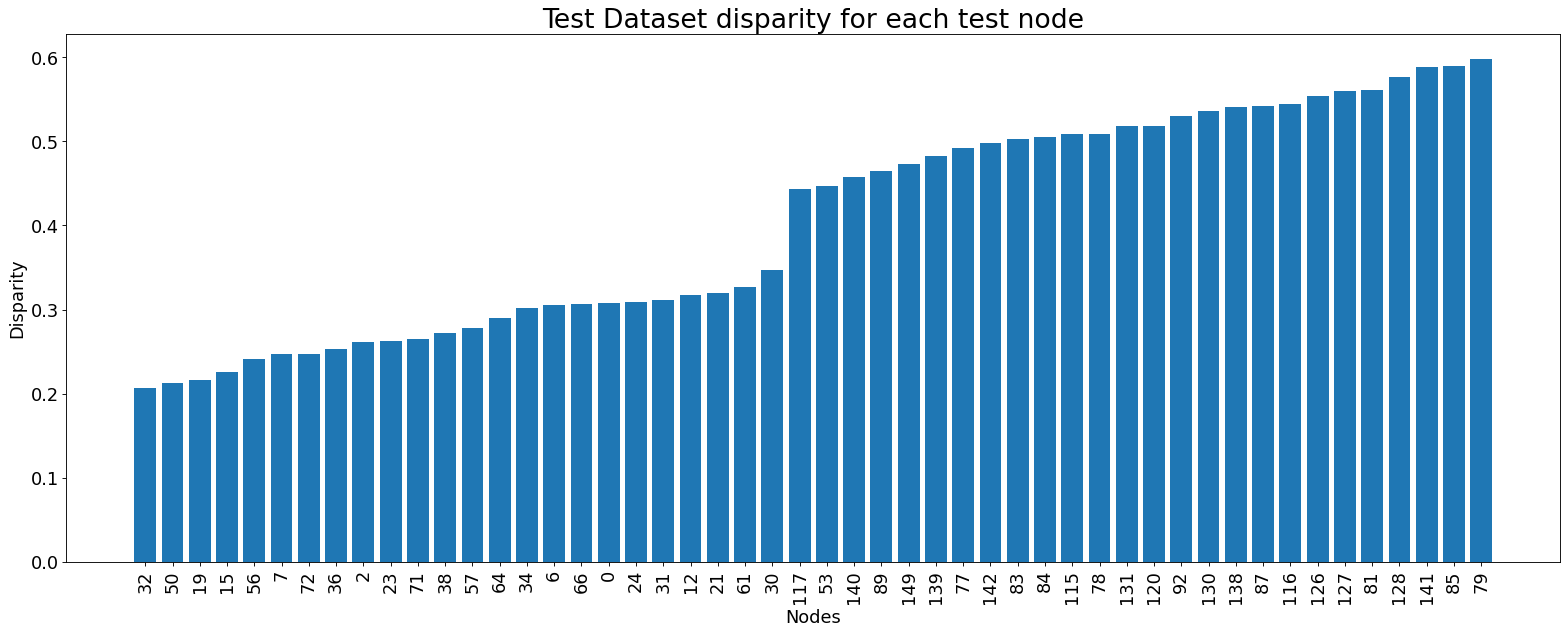

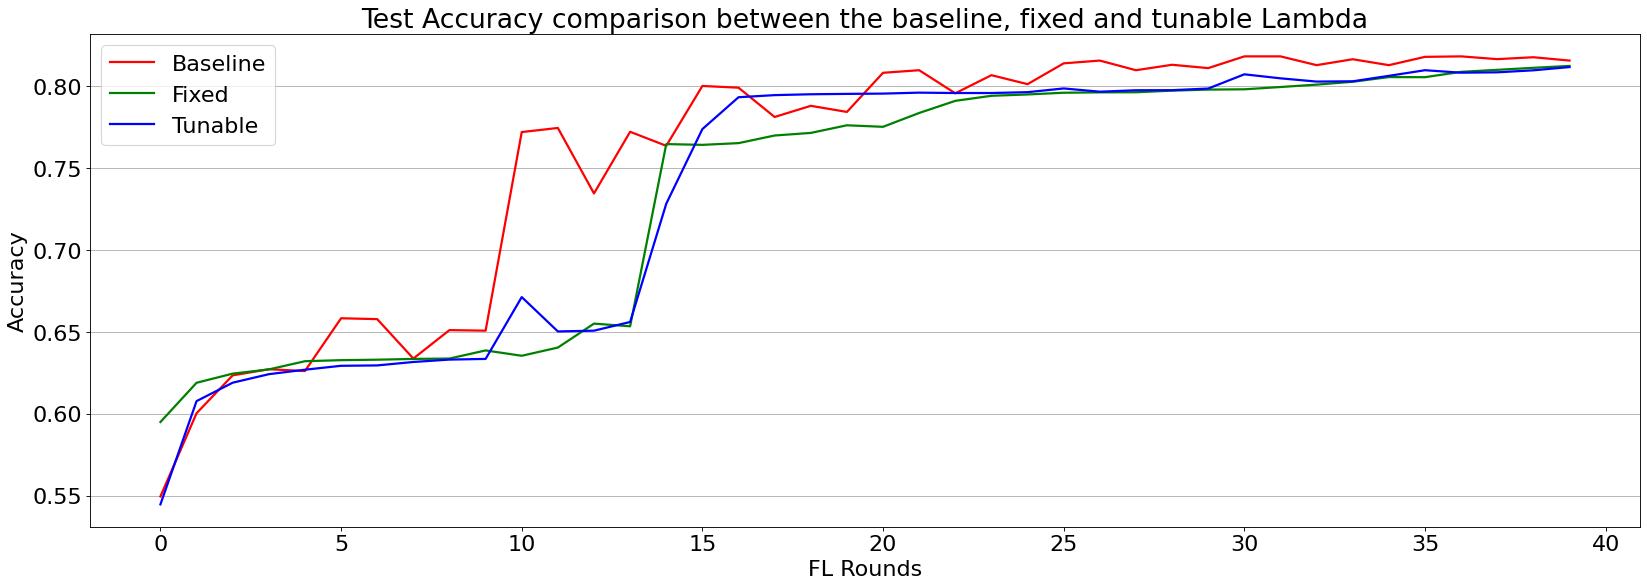

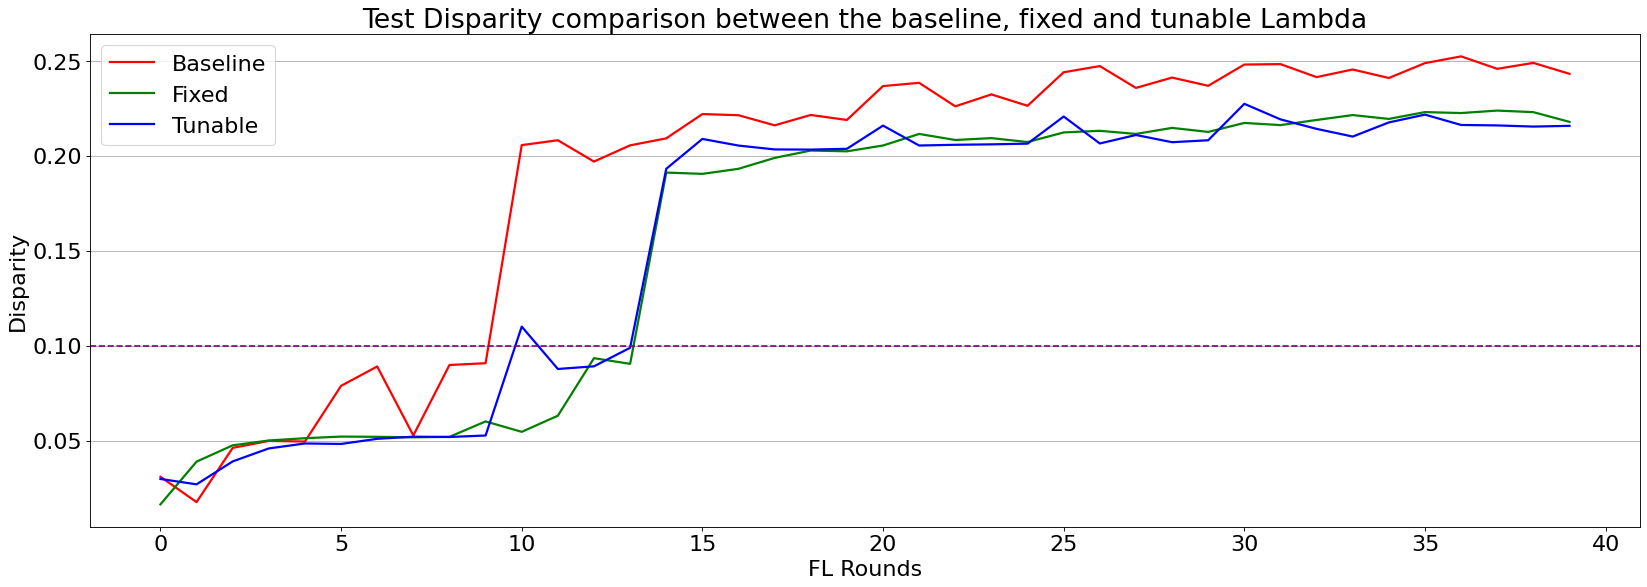

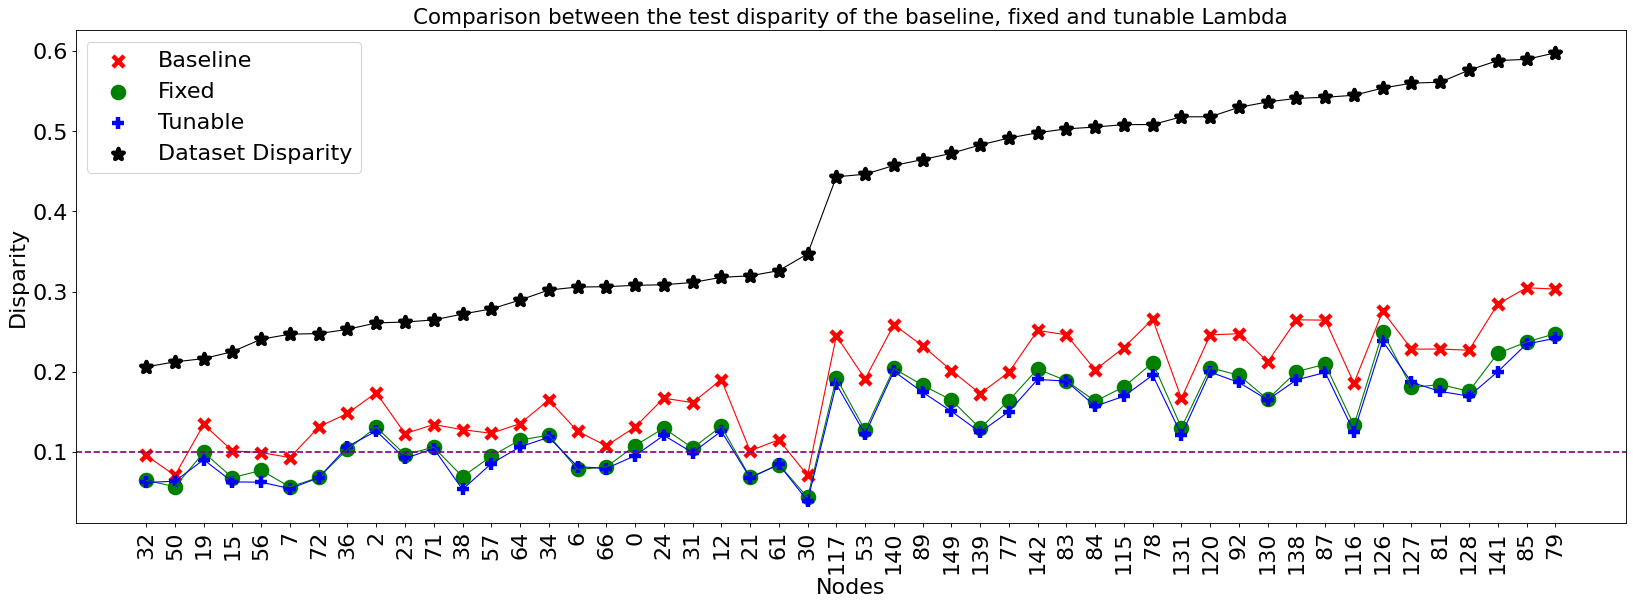

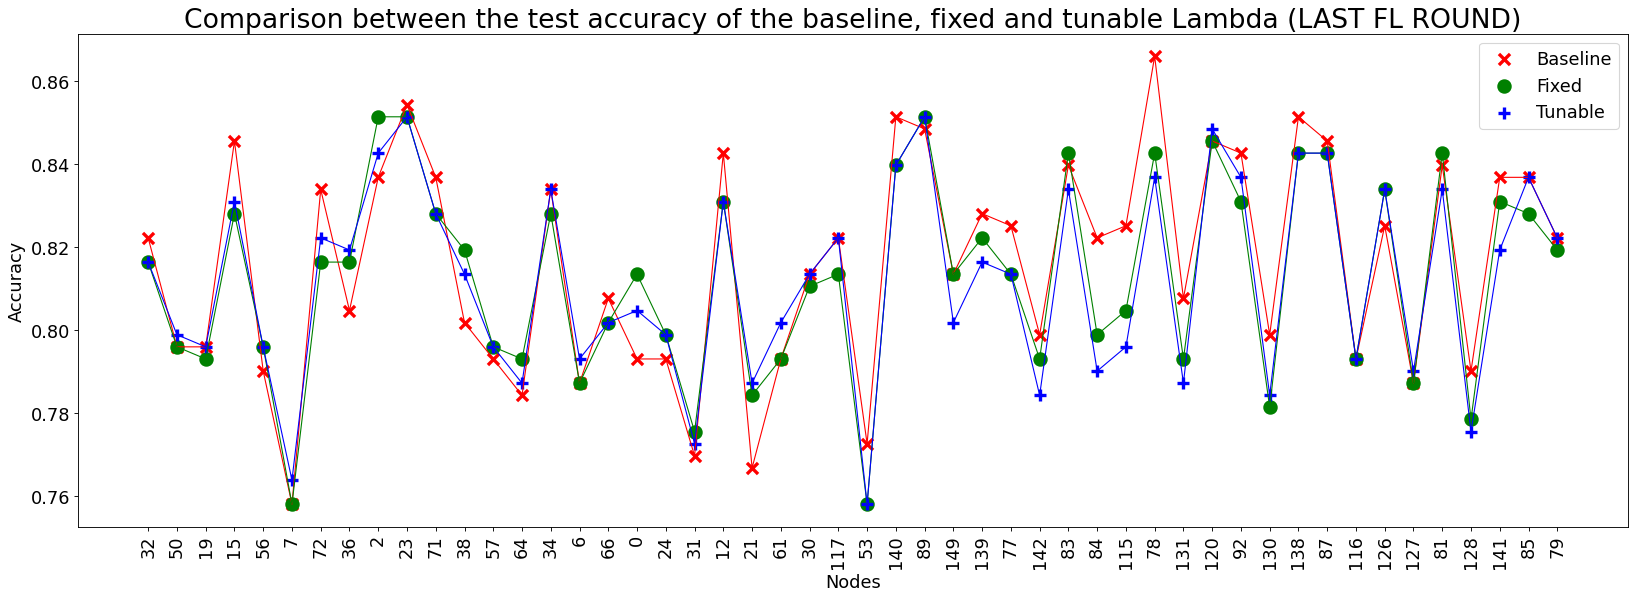

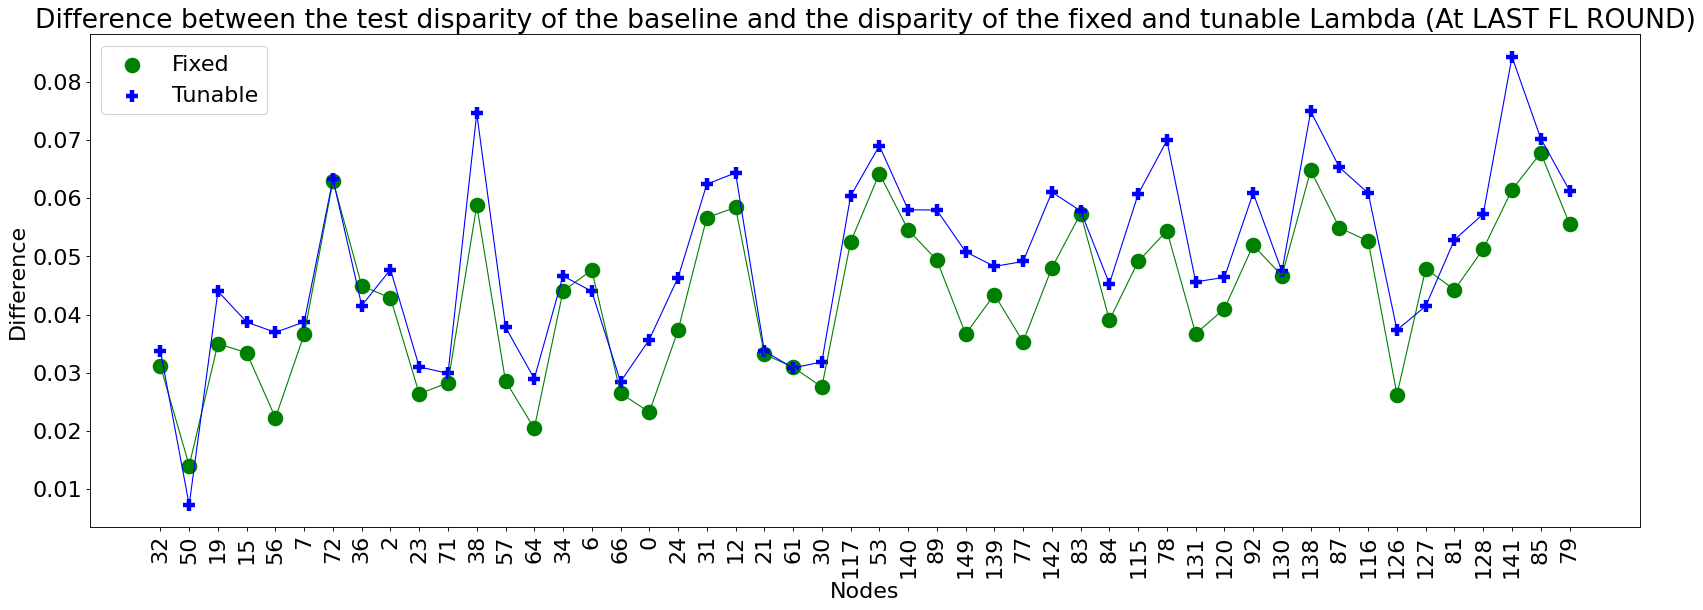

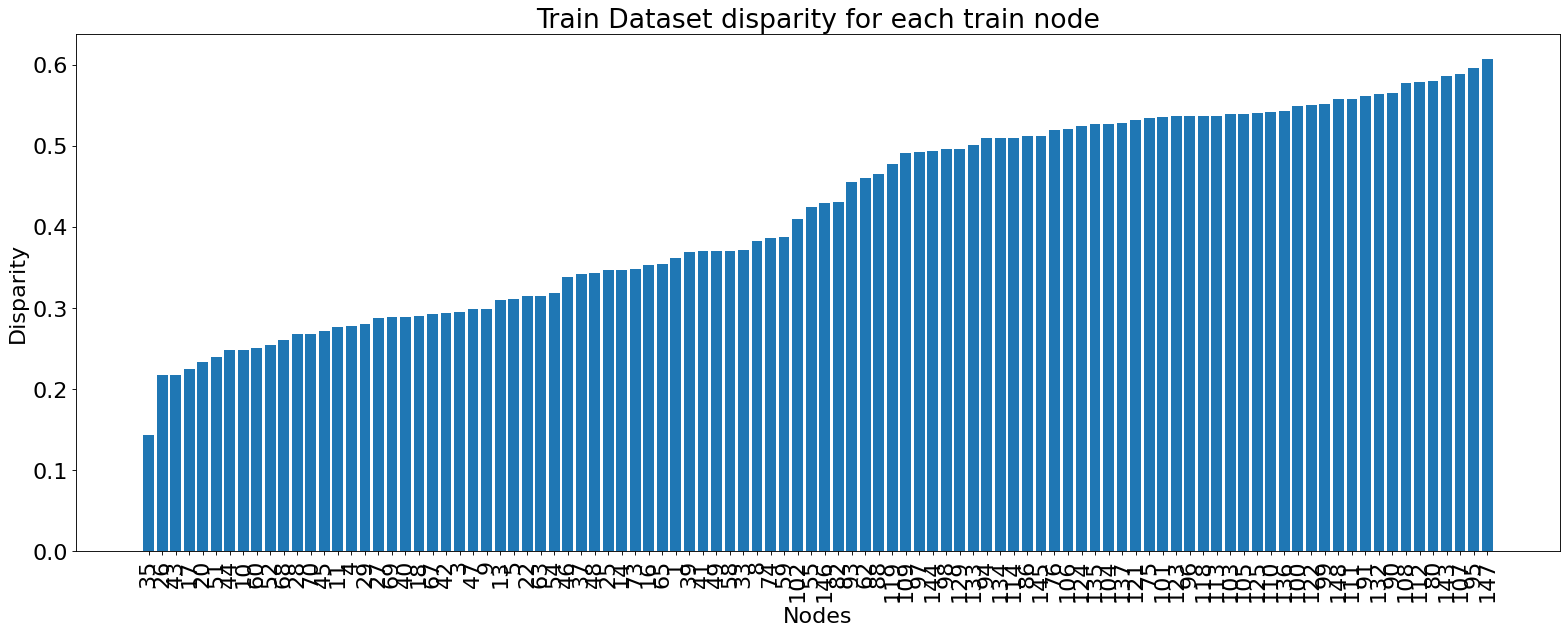

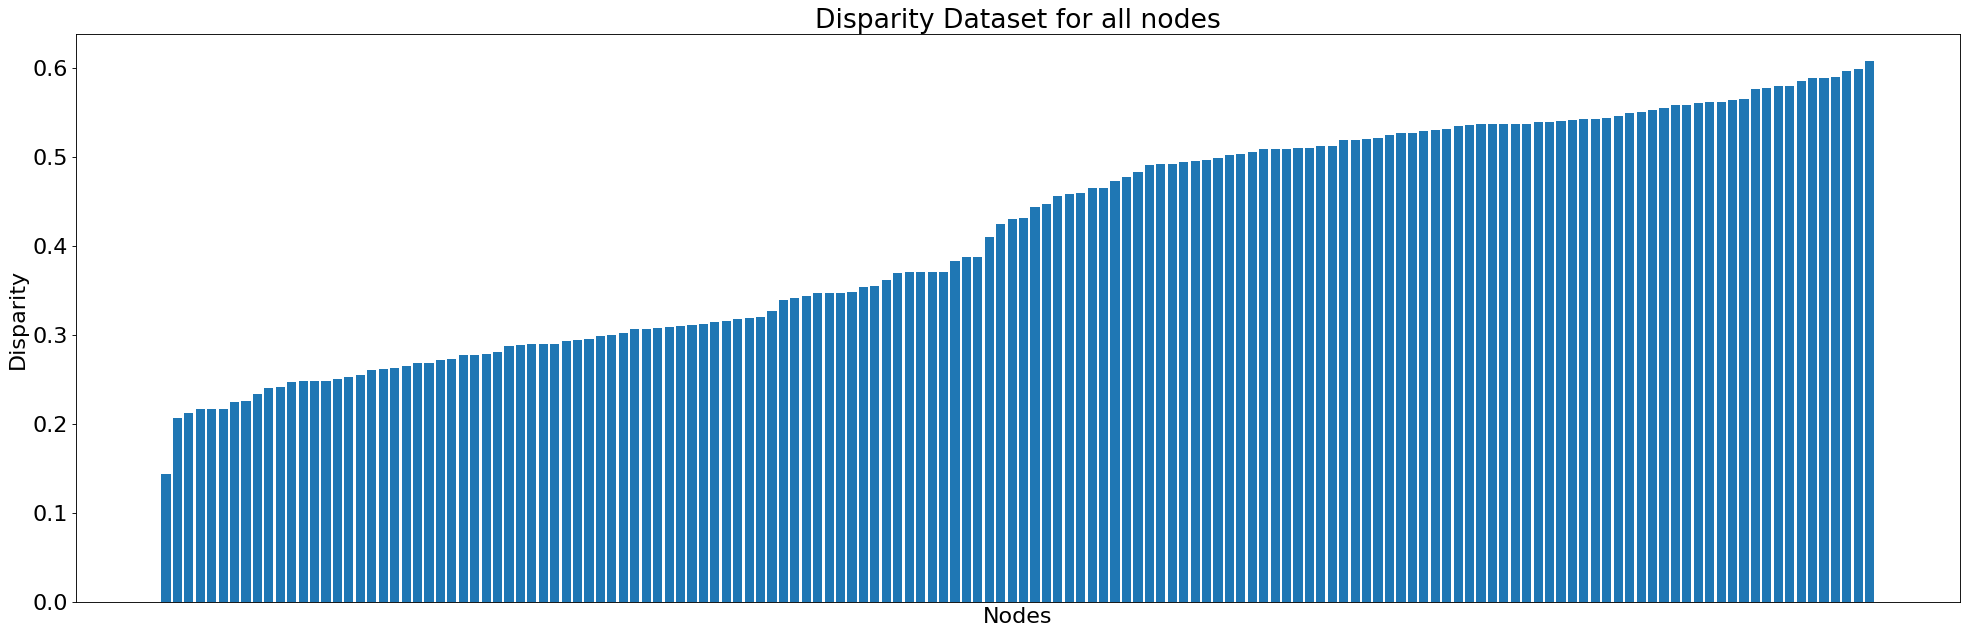

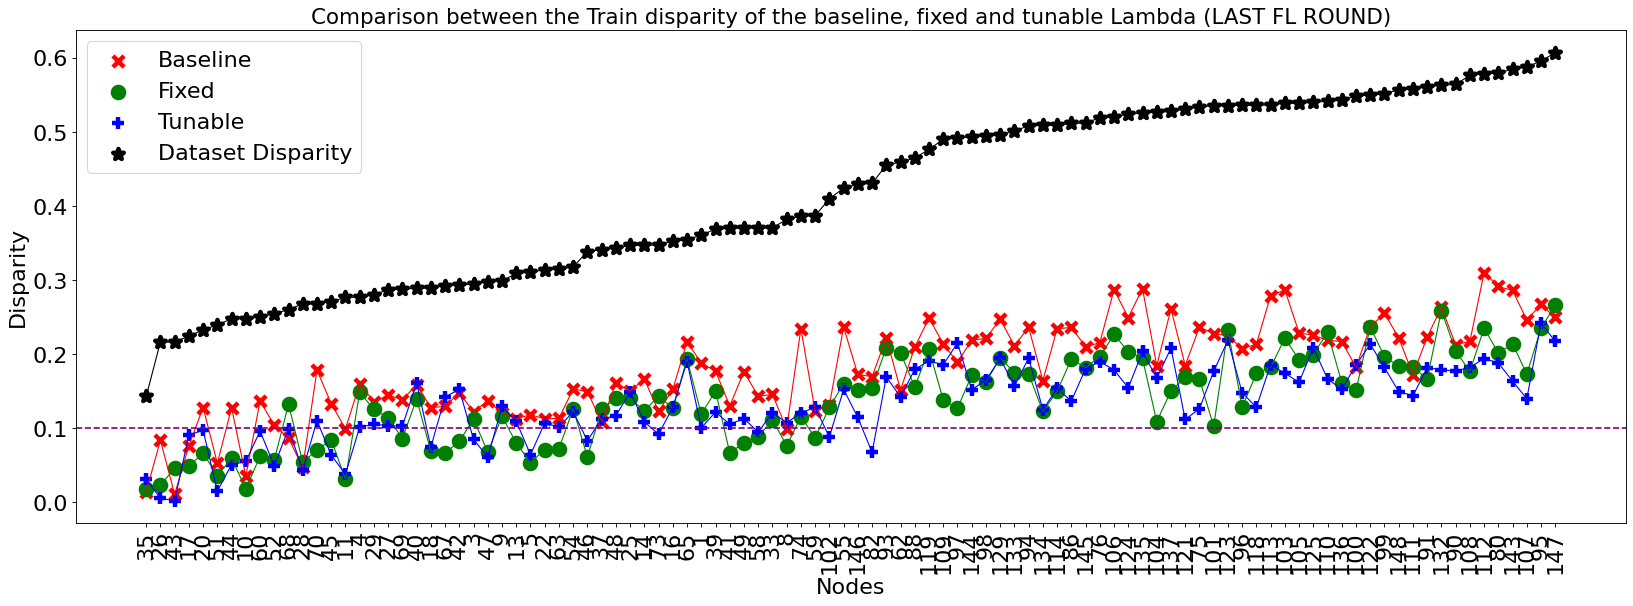

In [15]:
process_and_plot(
    baseline_link="/lucacorbucci/FL_fairness/runs/4ufqnvt8",
    fixed_link="/lucacorbucci/FL_fairness/runs/wihd5qpu",
    tunable_link="/lucacorbucci/FL_fairness/runs/j0hv6tlh",
    experiment="50_50",
    target=0.1,
    # df_baseline=df_baseline,
    # df_fixed=df_fixed,
    # df_tunable=df_tunable,
)

# 30% Balanced 70% Unbalanced

In [ ]:
# 50 balanced 50 unblalanced
process_and_plot(
    baseline_link="/lucacorbucci/FL_fairness/runs/f57qbv4s",
    fixed_link="/lucacorbucci/FL_fairness/runs/lvagj1io",
    tunable_link="/lucacorbucci/FL_fairness/runs/bthvijqh",
    experiment="30_70",
    target=0.05,
    # df_baseline=df_baseline,
    # df_fixed=df_fixed,
    # df_tunable=df_tunable,
)

# Non IID

In [ ]:
# baseline_link="/lucacorbucci/FL_fairness/runs/ng91bamk"
# fixed_link="/lucacorbucci/FL_fairness/runs/2jjx2hjh"
# tunable_link="/lucacorbucci/FL_fairness/runs/xunyy81c"
# df_baseline = get_df(baseline_link)
# df_fixed = get_df(fixed_link)
# df_tunable = get_df(tunable_link)

In [ ]:
# Non IID
process_and_plot(
    baseline_link="/lucacorbucci/FL_fairness/runs/ng91bamk",
    fixed_link="/lucacorbucci/FL_fairness/runs/2jjx2hjh",
    tunable_link="/lucacorbucci/FL_fairness/runs/xunyy81c",
    experiment="non_iid_celeba",
    target=0.1,
    # df_baseline=df_baseline,
    # df_fixed=df_fixed,
    # df_tunable=df_tunable,
)

# 50% Balanced 50% Unbalanced

70
--------------------------------------
------------ Test dataset ------------
--------------------------------------
++++++++++++ Accuracy ++++++++++++
++++++++++++ Disparity ++++++++++++
++++++++++++ Disparity Fixed vs Tunable ++++++++++++
{'15': 0.1502705216407776, '71': 0.1970532238483429, '0': 0.17605823278427124, '87': 0.19372710585594177, '19': 0.17636075615882874, '120': 0.15400570631027222, '85': 0.28349462151527405, '127': 0.21394093334674835, '32': 0.11034291982650757, '149': 0.18296217918395996, '38': 0.15907204151153564, '23': 0.15823405981063843, '126': 0.24108552932739258, '72': 0.1758541762828827, '7': 0.14390432834625244, '66': 0.14973124861717224, '2': 0.2171926498413086, '31': 0.19142159819602966, '128': 0.18898054957389832, '130': 0.15476861596107483, '89': 0.16283011436462402, '115': 0.1961507350206375, '131': 0.11656820774078369, '79': 0.28350138664245605, '36': 0.18307963013648987, '77': 0.12260383367538452, '81': 0.1322338879108429, '117': 0.17410075664520264,

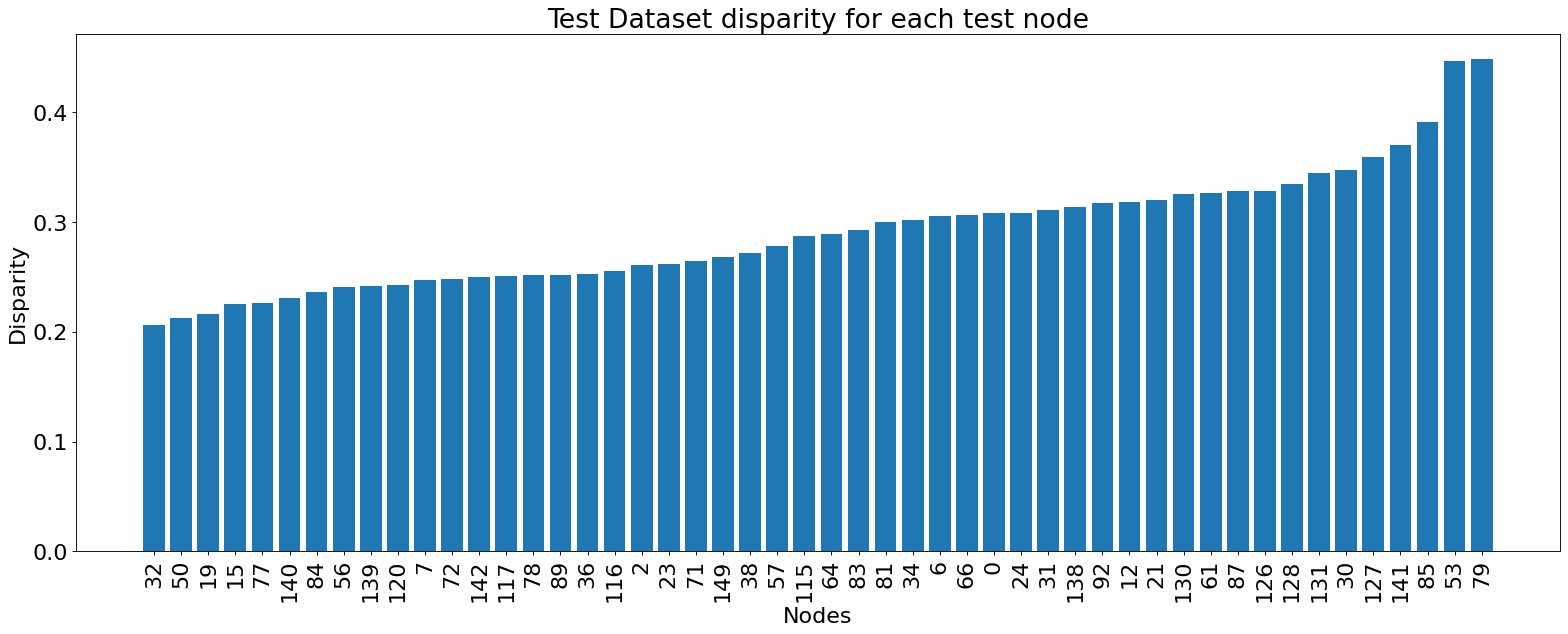

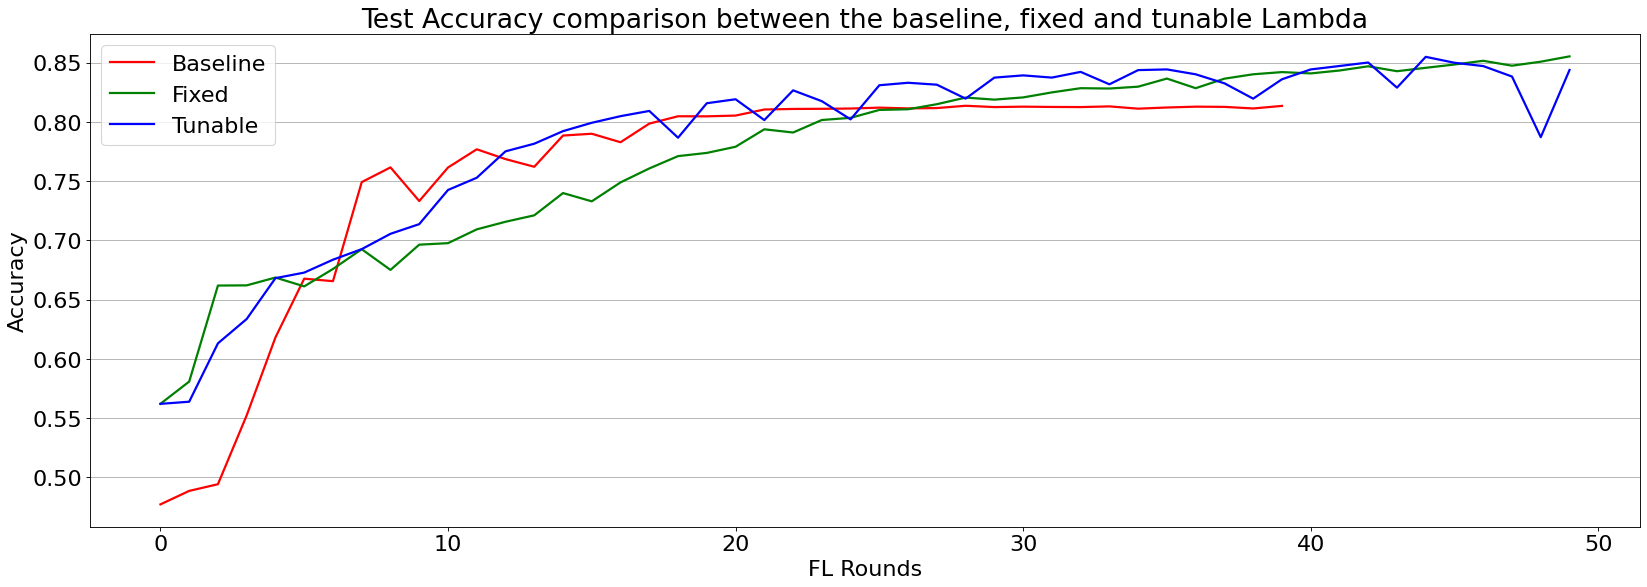

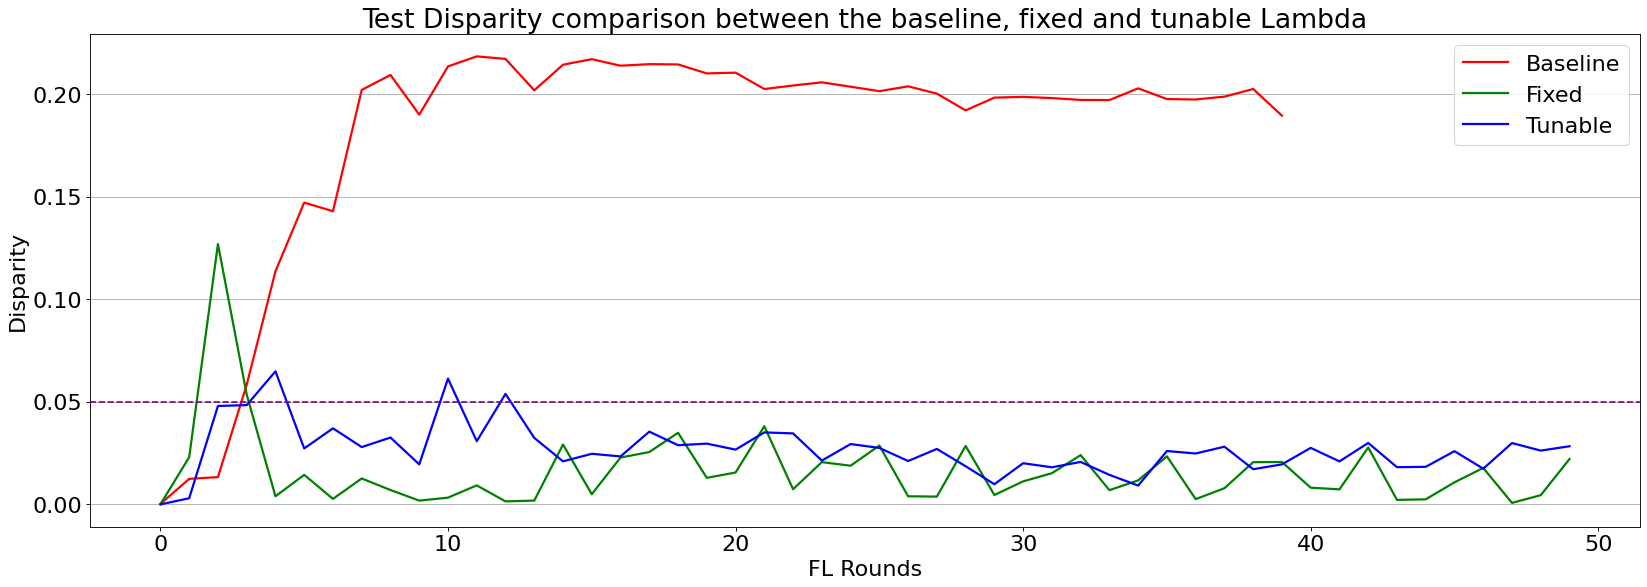

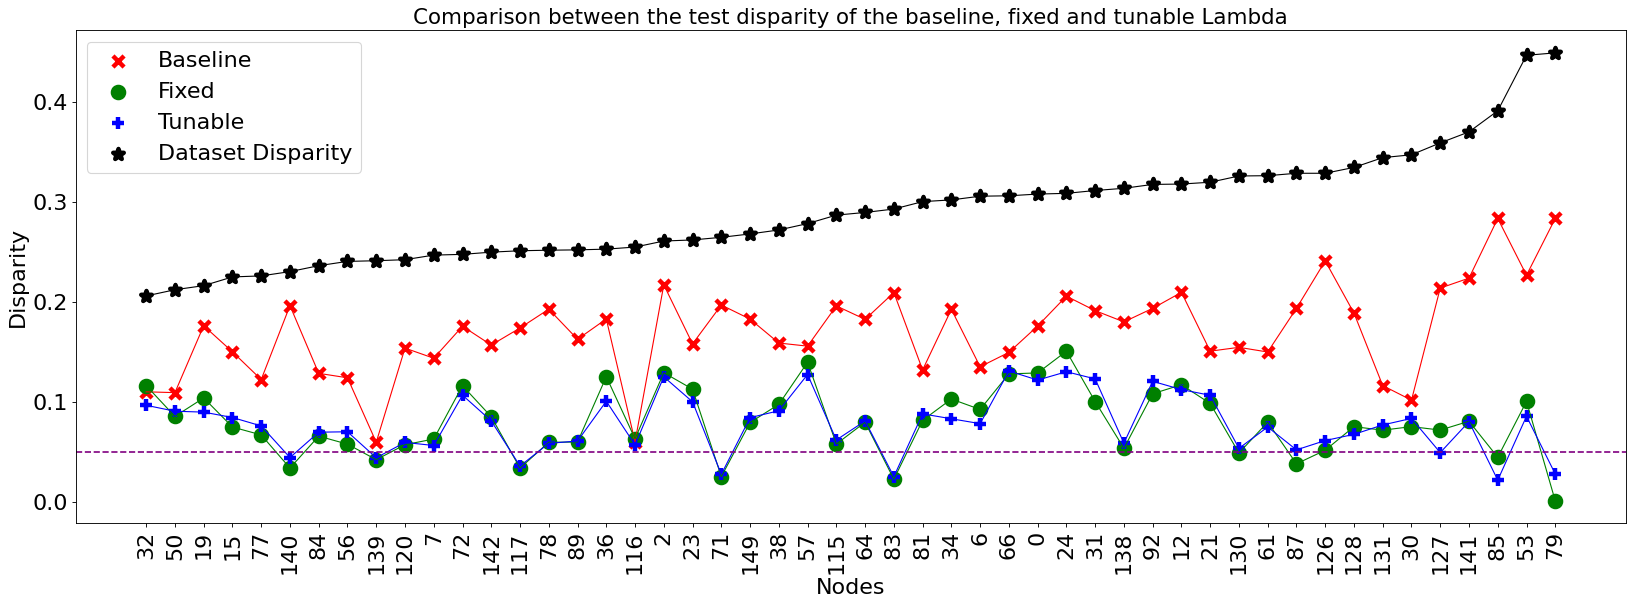

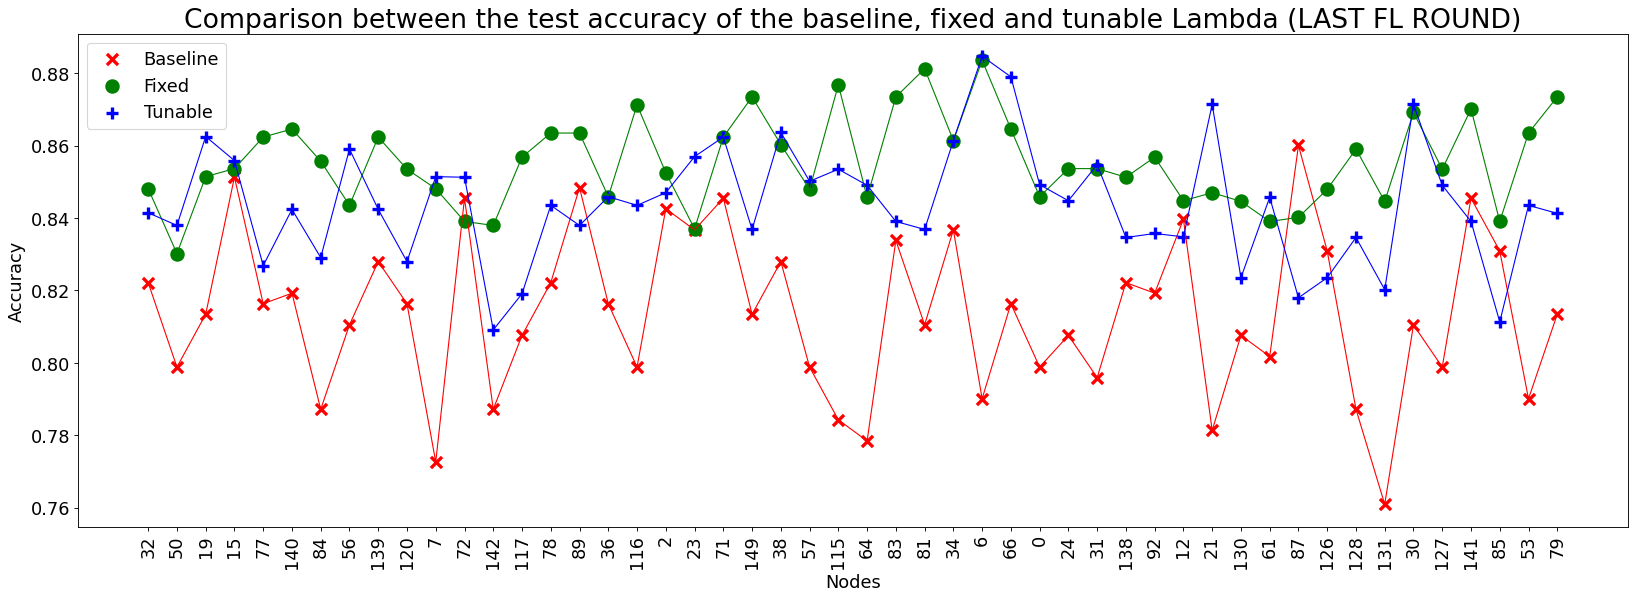

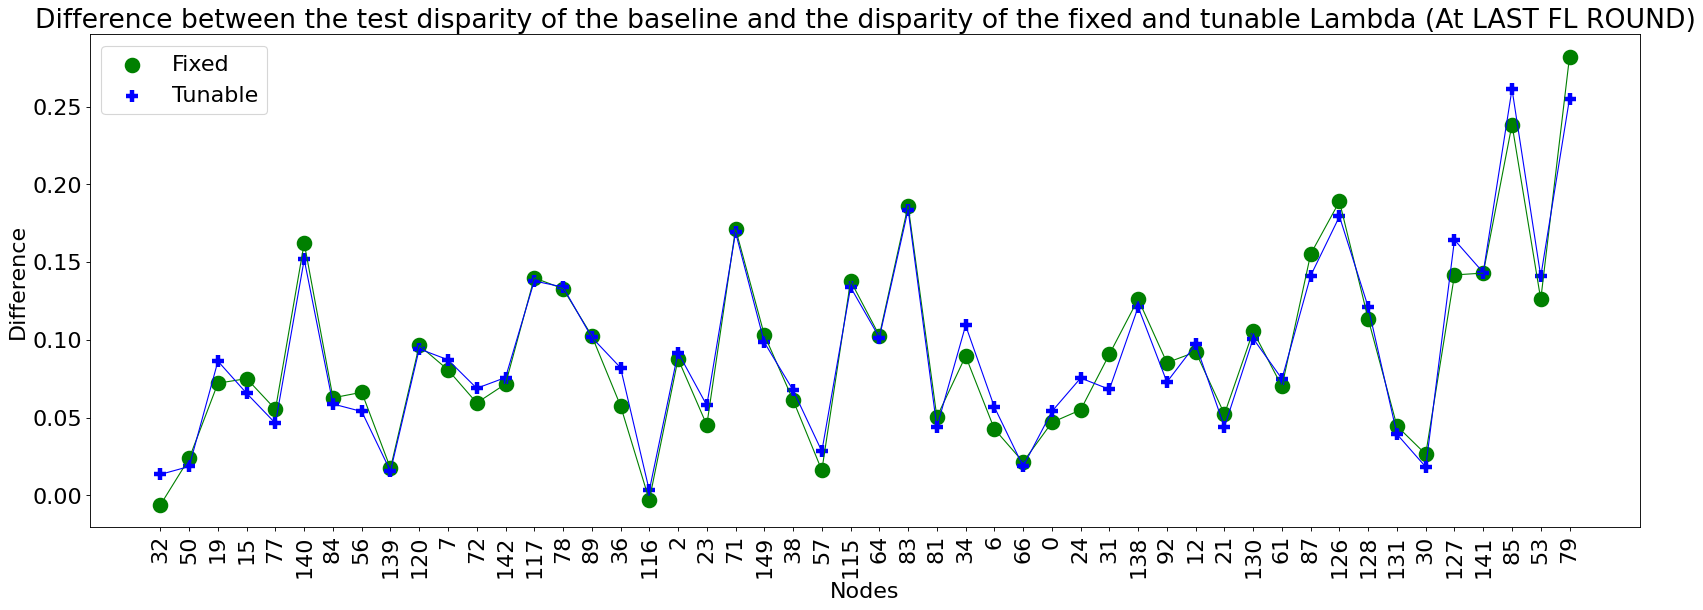

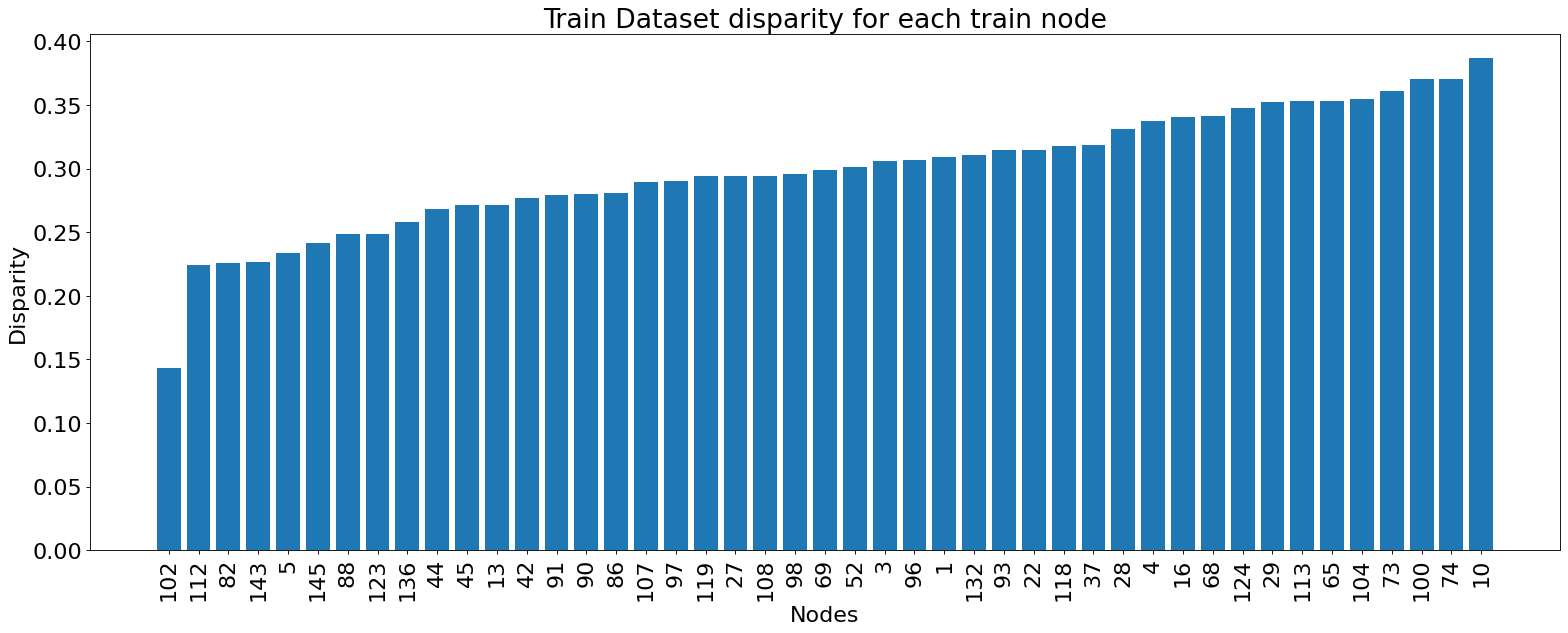

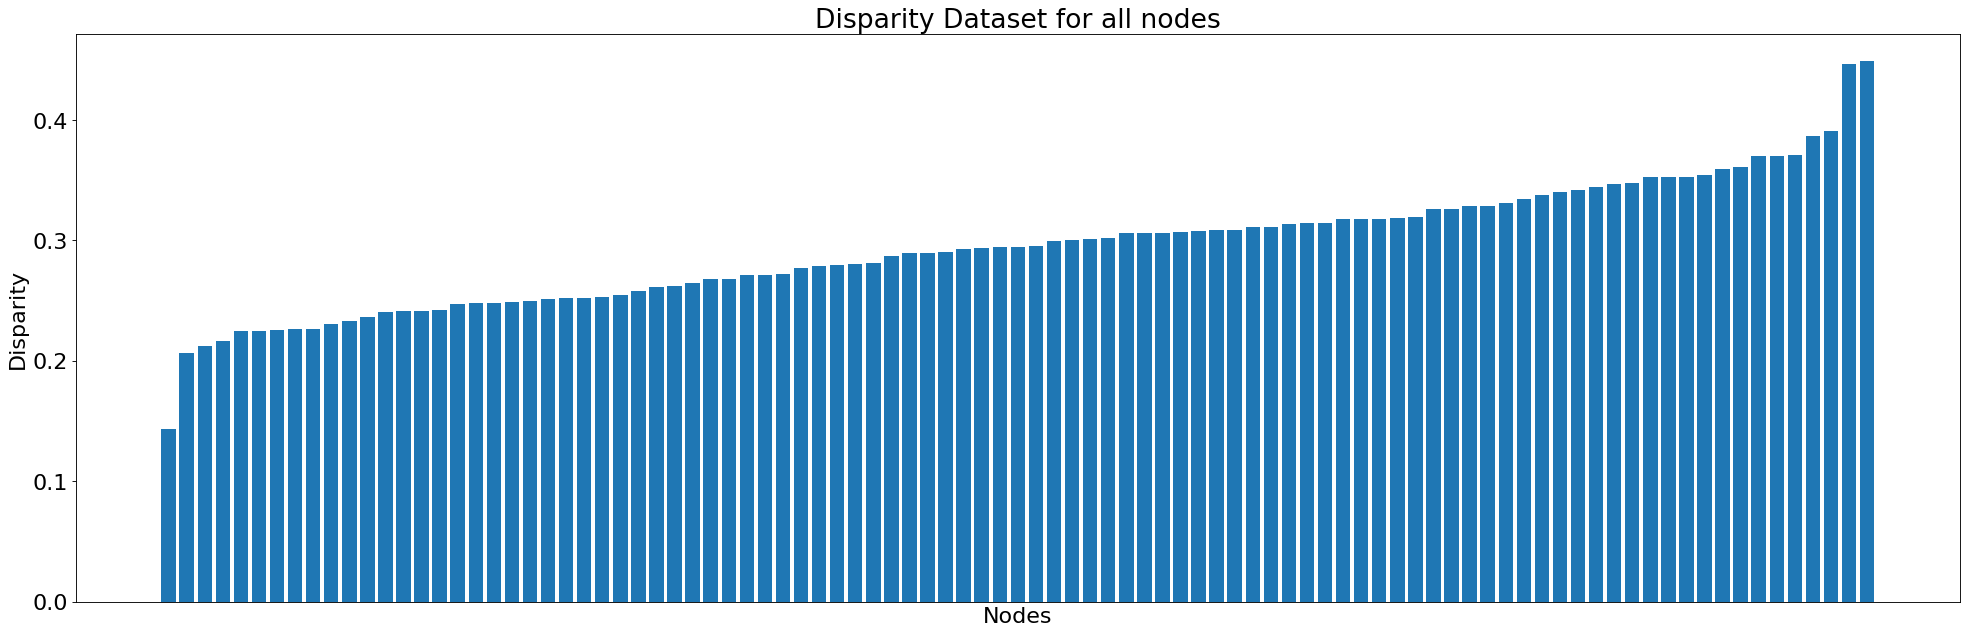

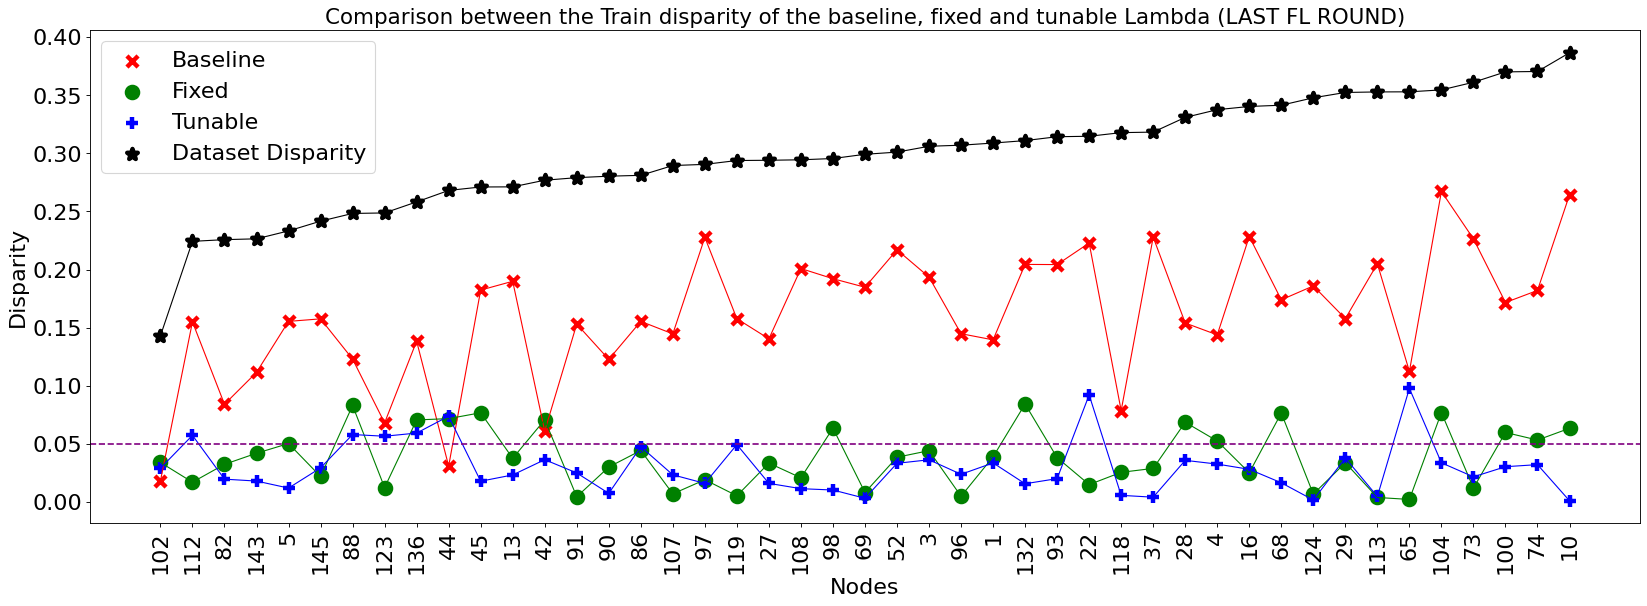

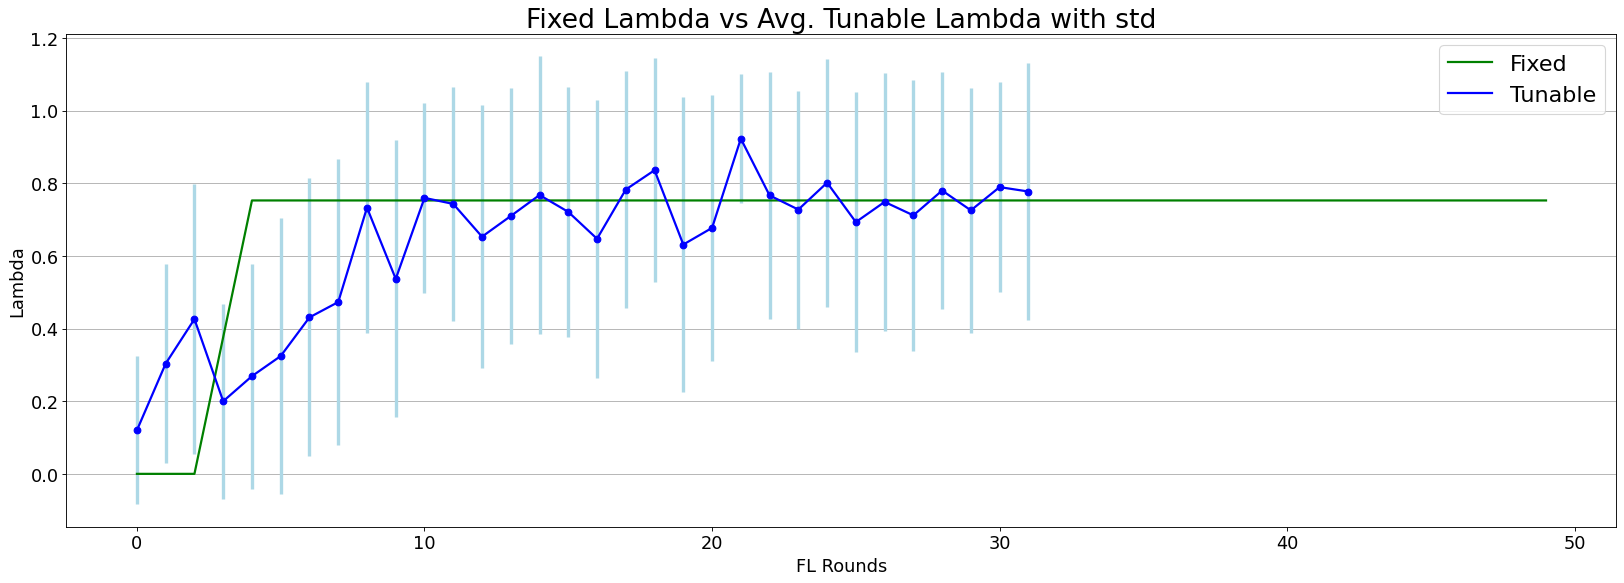

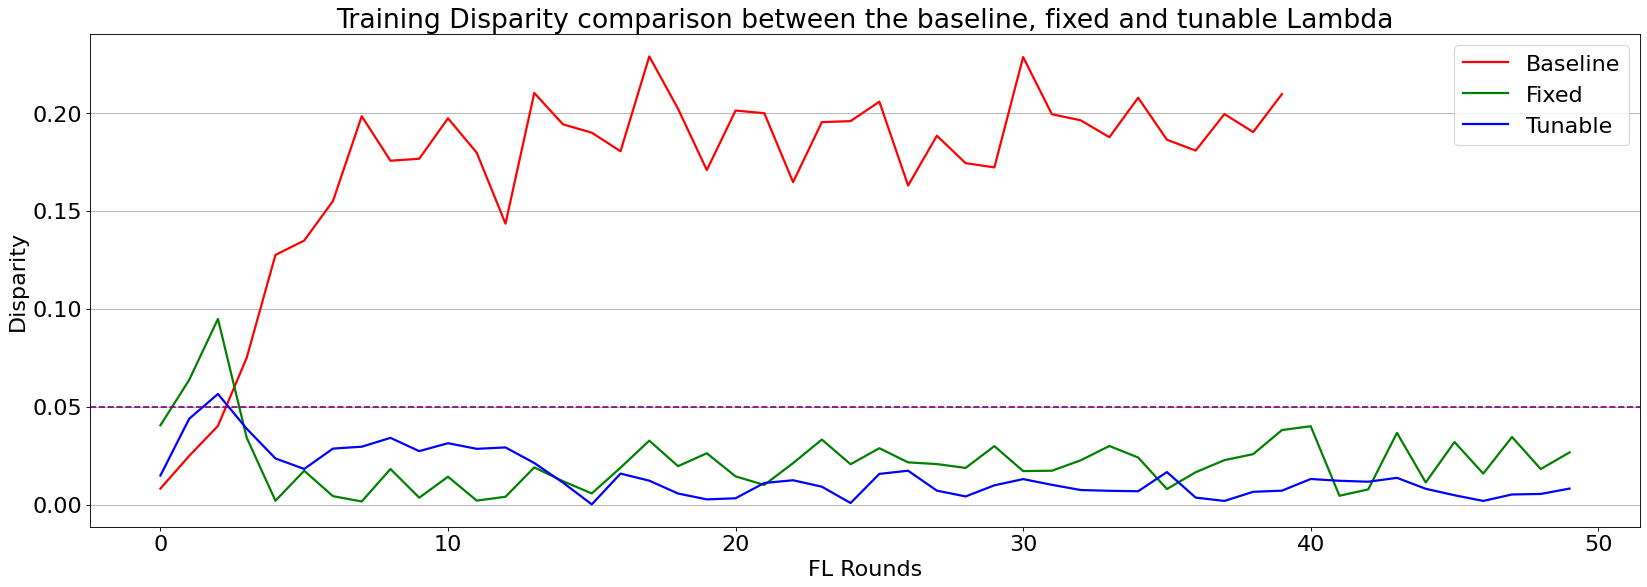

In [19]:
# 50 balanced 50 unbalanced
process_and_plot(
    baseline_link="/lucacorbucci/FL_PUF_Sweep/runs/5clh3ufa",
    fixed_link="/lucacorbucci/FL_fairness/runs/ewo63t3s",
    tunable_link="/lucacorbucci/FL_fairness/runs/gprysgcv",
    experiment="50_50",
    target=0.05,
)

# Dutch 

### Distribution 4

In [ ]:
# 50 balanced 50 unbalanced
process_and_plot(
    baseline_link="/lucacorbucci/FL_PUF_Sweep/runs/2cfee14h",
    fixed_link="/lucacorbucci/FL_PUF_Sweep/runs/qf5cy7yw",
    tunable_link="/lucacorbucci/FL_PUF_Sweep/runs/tpwzgoep",
    experiment="target_01_dutch_distribution_4",
    target=0.1,
)

#### Target 0.05

In [ ]:
# # 50 balanced 50 unbalanced
# process_and_plot(
#     baseline_link="/lucacorbucci/FL_PUF_Sweep/runs/fuwfcfb0",
#     fixed_link="/lucacorbucci/FL_PUF_Sweep/runs/y50gn8el",
#     tunable_link="/lucacorbucci/FL_PUF_Sweep/runs/4nosq9xd",
#     experiment="target_005",
#     target=0.05,
# )

# Dutch 2

In [ ]:
# # 50 balanced 50 unbalanced
# process_and_plot(
#     baseline_link="/lucacorbucci/FL_PUF_Sweep/runs/wh898buc",
#     fixed_link="/lucacorbucci/FL_PUF_Sweep/runs/ts03o4m8",
#     tunable_link="/lucacorbucci/FL_PUF_Sweep/runs/3ppsttus",
#     experiment="target_01",
#     target=0.1,
# )

In [ ]:
# baseline_link="/lucacorbucci/FL_fairness/runs/ydjnxo29"
# df_baseline = get_df(baseline_link)
# baseline_test_nodes_columns_disparity_dataset = remove_nan(test_nodes_columns_disparity_dataset, df_baseline)

# nodes_with_disparity = {}
# for node_name, column in zip(test_nodes, baseline_test_nodes_columns_disparity_dataset.columns):
#     # get the last value of the column
#     nodes_with_disparity[node_name] = baseline_test_nodes_columns_disparity_dataset[column].iloc[-1]
# # dump nodes_with_disparity.values() in a file
# dill.dump(nodes_with_disparity, open("nodes_with_disparity_test.pkl", "wb"))

In [ ]:
# baseline_link="/lucacorbucci/FL_fairness/runs/ydjnxo29"
# df_baseline = get_df(baseline_link)
# baseline_test_nodes_columns_disparity_dataset = remove_nan(test_nodes_columns_disparity_dataset, df_baseline)

# nodes_with_disparity = {}
# for node_name, column in zip(test_nodes, baseline_test_nodes_columns_disparity_dataset.columns):
#     # get the last value of the column
#     nodes_with_disparity[node_name] = baseline_test_nodes_columns_disparity_dataset[column].iloc[-1]
# # dump nodes_with_disparity.values() in a file
# dill.dump(nodes_with_disparity, open("nodes_with_disparity_train.pkl", "wb"))

In [ ]:
# tunable_link = "/lucacorbucci/FL_fairness/runs/gprysgcv"
# df_tunable = get_df(tunable_link)

In [ ]:
# lambda_columns = df_tunable[train_nodes_columns]
# disparity_columns_before = df_tunable[train_nodes_columns_disparity_before]
# disparity_columns_after = df_tunable[train_nodes_columns_disparity]

In [ ]:
# lambdas = {}
# for column_name in lambda_columns.columns:
#     node_name = str(column_name.split(" ")[2])
#     lambdas[node_name] = list(lambda_columns[column_name].dropna())

# disparities_before = {}
# for column_name in disparity_columns_before.columns:
#     node_name = str(column_name.split(" ")[2])
#     disparities_before[node_name] = list(disparity_columns_before[column_name].dropna())

# disparities_after = {}
# for column_name in disparity_columns_after.columns:
#     node_name = str(column_name.split(" ")[2])
#     disparities_after[node_name] = list(disparity_columns_after[column_name].dropna())

In [ ]:
# # plot the lambdas
# figure(figsize=(25, 8), dpi=80)
# ax = plt.axes()
# ax.yaxis.grid()
# for node_name, values in lambdas.items():
#     if int(node_name) <= 75:
#         plt.plot(values, linewidth=2, label=node_name)
# plt.xlabel("FL Rounds")
# plt.ylabel("Lambda")
# plt.title(f"Lambda for each unfair node")
# plt.savefig("Lambda_for_each_unfair_node.png")

In [ ]:
# # plot the lambdas
# figure(figsize=(25, 8), dpi=80)
# ax = plt.axes()
# ax.yaxis.grid()
# for node_name, values in lambdas.items():
#     if int(node_name) > 75:
#         plt.plot(values, linewidth=2, label=node_name)
# plt.xlabel("FL Rounds")
# plt.ylabel("Lambda")
# plt.title(f"Lambda for each fair node")
# plt.savefig("Lambda_for_each_fair_node.png")

In [ ]:
# # plot the lambdas
# figure(figsize=(25, 8), dpi=80)
# ax = plt.axes()
# ax.yaxis.grid()
# for node_name, values in lambdas.items():
#     if int(node_name) <= 75:
#         plt.plot(values, linewidth=2, label=node_name)
# plt.xlabel("FL Rounds")
# plt.ylabel("Lambda")
# plt.title(f"Disparity Before the local epochs for each unfair node")
# plt.savefig("disparity_before_for_each_unfair_node.png")

In [ ]:
# # plot the lambdas
# figure(figsize=(25, 8), dpi=80)
# ax = plt.axes()
# ax.yaxis.grid()
# for node_name, values in lambdas.items():
#     if int(node_name) > 75:
#         plt.plot(values, linewidth=2, label=node_name)
# plt.xlabel("FL Rounds")
# plt.ylabel("Lambda")
# plt.title(f"Disparity Before the local epochs for each fair node")
# plt.savefig("disparity_before_for_each_fair_node.png")

In [ ]:
# # plot the lambdas
# figure(figsize=(25, 8), dpi=80)
# ax = plt.axes()
# ax.yaxis.grid()
# for node_name, values in lambdas.items():
#     if int(node_name) <= 75:
#         plt.plot(values, linewidth=2, label=node_name)
# plt.xlabel("FL Rounds")
# plt.ylabel("Lambda")
# plt.title(f"Disparity After the local epochs for each unfair node")
# plt.savefig("disparity_after_for_each_unfair_node.png")

In [ ]:
# # plot the lambdas
# figure(figsize=(25, 8), dpi=80)
# ax = plt.axes()
# ax.yaxis.grid()
# for node_name, values in lambdas.items():
#     if int(node_name) > 75:
#         plt.plot(values, linewidth=2, label=node_name)
# plt.xlabel("FL Rounds")
# plt.ylabel("Lambda")
# plt.title(f"Disparity After the local epochs for each fair node")
# plt.savefig("disparity_after_for_each_fair_node.png")